# Machine Learning Classification Project: Income Prediction
## Logistic Regression, Standardization, One-Hot Encoding, & Scoring Function Engineering

In this project, I used logistic regression for a classification task: classifiying an individual's income based on their demographic characteristics, occupational status, hours worked, and other variables.
The dataset used can be found below:

https://www.kaggle.com/uciml/adult-census-income

In this project, the **target variable** is **Income**, which takes on two classes: <=50K, or >50K.

The predictors are both continuous and categorical: <br>
Continuous variables used are _age_, _fnlwgt_ (a census weight), _years of education_, _capital gains_, _capital losses_, and _hours worked per week_. <br>
Categorical variables used are _work classification_, _education_, _marital status_, _occupation_, _relationship status_, _race_, _sex_, and _native country_. 

In [87]:
import numpy as np
import pandas as pd

In [123]:
data = pd.read_csv('adult.csv')

In [89]:
data

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [90]:
data.describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [91]:
data.shape

(48842, 15)

In [126]:
income_tr = data.iloc[0:36000,:]
income_te = data.iloc[36000:,:]

print(income_tr.shape)
print(income_te.shape)

(36000, 15)
(12842, 15)


In [127]:
# Data cleaning: some rows contain ? characters in lieu of usable data; discard those rows
income_tr = income_tr.replace('?',np.nan).dropna(axis=0, how='any')
income_te = income_te.replace('?',np.nan).dropna(axis=0, how='any')

print(income_tr.shape)
print(income_te.shape)

# Define X_test as cleaned test set
X_test = income_te.iloc[:,0:14]
y_test = income_te.iloc[:,14]

(33337, 15)
(11885, 15)


In [128]:
# Split training data into X and y
X = income_tr.loc[:, income_tr.columns != 'income']
y = income_tr.loc[:, 'income']

print(X.shape)
print(y.shape)

(33337, 14)
(33337,)


#### Standardization

In [129]:
from sklearn.preprocessing import StandardScaler

cont_feats = ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
cat_feats = [feat for feat in X.columns if feat not in cont_feats]

# Initialize StandardScaler
scaler = StandardScaler()

# Fit StandardScaler to training data
scaler.fit(X[cont_feats])

# Standardize continuous features in training data
standardized_X_tr = pd.DataFrame(scaler.transform(X[cont_feats]))

# Standardize continuous features in testing data with same fit for consistency
standardized_X_te = pd.DataFrame(scaler.transform(X_test[cont_feats]))

#### One-Hot Encoding

In [130]:
from sklearn.preprocessing import OneHotEncoder

# Initialize OneHotEncoder
enc = OneHotEncoder(sparse=False)

# Fit OneHotEncoder to training data
enc.fit(X[cat_feats])

# One-hot Encode categorical features in training data
encoded_X_tr = pd.DataFrame(enc.transform(X[cat_feats]), columns = enc.get_feature_names(cat_feats))

# One-hot Encode categorical features in testing data with same fit for consistency
encoded_X_te = pd.DataFrame(enc.transform(X_test[cat_feats]), columns = enc.get_feature_names(cat_feats))

In [131]:
# Reconstruct X and X_test DataFrames
X = standardized_X_tr.join(encoded_X_tr)
X_test = standardized_X_te.join(encoded_X_te)

# Restore standardized column names
cols = X.columns.tolist()
cols[0:6] = cont_feats
X.columns = cols
X_test.columns = cols

# Confirm DataFrames reconstructed correctly
print(standardized_X_tr.shape)
print(encoded_X_tr.shape)
print(X.shape)

print(standardized_X_te.shape)
print(encoded_X_te.shape)
print(X_test.shape)

(33337, 6)
(33337, 98)
(33337, 104)
(11885, 6)
(11885, 98)
(11885, 104)


In [98]:
X.head()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,-1.025905,0.351340,-1.226169,-0.145540,-0.21999,-0.077038,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.045963,-0.946167,-0.439661,-0.145540,-0.21999,0.758511,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.799764,1.394637,0.740102,-0.145540,-0.21999,-0.077038,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.406319,-0.278328,-0.046407,0.879421,-0.21999,-0.077038,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.347483,0.085101,-1.619424,-0.145540,-0.21999,-0.912588,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [132]:
# Create validation sets
X_train = X.iloc[:26000,:]
y_train = y.iloc[:26000,]
X_val = X.iloc[26000:,:]
y_val = y.iloc[26000:,]

In [133]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(26000, 104)
(7337, 104)
(11885, 104)


#### Logistic Regression

In [134]:
from sklearn.linear_model import LogisticRegression

# Initialize and fit LogisticRegression classifier to training data
logist = LogisticRegression(max_iter=400)
logist.fit(X_train, y_train)

LogisticRegression(max_iter=400)

In [135]:
# Predict classifications for validation dataset
y_pred_val = logist.predict(X_val)

In [63]:
print(y_val)
print(y_pred_val)

28119    <=50K
28120     >50K
28121    <=50K
28122     >50K
28123     >50K
         ...  
35995    <=50K
35996    <=50K
35997     >50K
35998    <=50K
35999    <=50K
Name: income, Length: 7337, dtype: object
['<=50K' '<=50K' '<=50K' ... '>50K' '<=50K' '<=50K']


#### Scoring

To test the logistic regression model's performance on this task, I engineered three common scoring methods.

In [61]:
# Returns precision, which is TP/(TP+FP)
def precision(y, y_preds):
    TP=0
    FP=0
    
    for i in range(len(y_preds)):
        if y_preds[i] == y.iloc[i] and y_preds[i] == '>50K':
            TP += 1
        if y_preds[i] != y.iloc[i] and y_preds[i] == '>50K':
            FP += 1
            
    return((TP/(TP+FP)))

# Returns recall, which is TP/(TP+FN)
def recall(y, y_preds):
    TP=0
    FN=0
    
    for i in range(len(y_preds)):
        if y_preds[i] == y.iloc[i] and y_preds[i] == '>50K':
            TP += 1
        if y_preds[i] != y.iloc[i] and y_preds[i] == '<=50K':
            FN += 1
            
    return((TP/(TP+FN)))

# Returns accuracy which is (TP+TN)/(TP+FP+FN+TN)
def accuracy(y, y_preds):
    TP=0
    TN=0
    FP=0
    FN=0
    
    for i in range(len(y_preds)):
        if y_preds[i] == y.iloc[i] and y_preds[i] == '>50K':
            TP += 1
        if y_preds[i] == y.iloc[i] and y_preds[i] == '<=50K':
            TN += 1
        if y_preds[i] != y.iloc[i] and y_preds[i] == '>50K':
            FP += 1
        if y_preds[i] != y.iloc[i] and y_preds[i] == '<=50K':
            FN += 1
            
    return((TP+TN)/(TP+FP+FN+TN))

In [62]:
print(f'Precision: {(precision(y_val,y_pred_val)*100):.2f}%')
print(f'Recall: {(recall(y_val,y_pred_val)*100):.2f}%')
print(f'Accuracy: {(accuracy(y_val,y_pred_val)*100):.2f}%')

Precision: 73.58%
Recall: 60.27%
Accuracy: 84.93%


Since we care equally about our model's ability to classify negative and positive observations, the Accuracy measure is most important here. 

0.9044671834065732


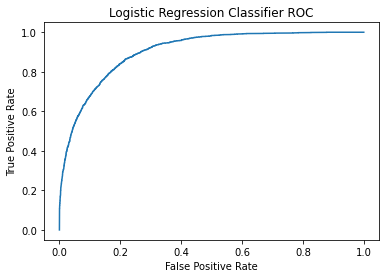

In [64]:
from sklearn.metrics import roc_curve
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

y_val_pred_score = logist.decision_function(X_val)

fpr, tpr, _ = roc_curve(y_val, y_val_pred_score, pos_label=logist.classes_[1])
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.title("Logistic Regression Classifier ROC")
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)

The AUC for our model is approximately 0.904 -- not bad at all.

#### Model Tuning/Hyperparameters

Although our model looks great with default hyperparameters, there's no reason to not try to tune it. <br>
'C' is a hyperparameter ranging from 0 to 1 controlling a complexity penalty: essentially, it controls regularization. With higher values, it trusts the training data more than with lower values, where it's more likely to penalize extreme coefficients resulting from the training data fit. <br>
'Penalty' specifies the type of regularization used: 'l1' refers to Lasso regularization, whereas 'l2' refers to Ridge. <br>
By default, LogisticRegression uses L2 regularization and a C = 1. Different solvers are needed for L1 regularization.

Build a logistic regression model with hyperparameter 'C' set to 0.1 and penalty set to 'l1'. Make predictions on validation set and compute accuracy, precision and recall. 


In [77]:
logist2 = LogisticRegression(C=0.1, penalty='l1', solver='saga', max_iter=2000)
logist2.fit(X_train, y_train)
y_pred_val2 = logist2.predict(X_val)

print(f'Precision: {(precision(y_val,y_pred_val2)*100):.2f}%')
print(f'Recall: {(recall(y_val,y_pred_val2)*100):.2f}%')
print(f'Accuracy: {(accuracy(y_val,y_pred_val2)*100):.2f}%')

Precision: 73.68%
Recall: 59.66%
Accuracy: 84.86%


Build a model with hyperparameter 'C' set to 0.5 and penalty set to 'l1'. Make predictions on validation set and compute accuracy, precision and recall. 


In [67]:
logist3 = LogisticRegression(C=0.5, penalty='l1', solver='saga', max_iter=2000)
logist3.fit(X_train, y_train)
y_pred_val3 = logist3.predict(X_val)

print(f'Precision: {(precision(y_val,y_pred_val3)*100):.2f}%')
print(f'Recall: {(recall(y_val,y_pred_val3)*100):.2f}%')
print(f'Accuracy: {(accuracy(y_val,y_pred_val3)*100):.3f}%')

Precision: 73.78%
Recall: 60.43%
Accuracy: 85.007%


Build a model with hyperparameter 'C' set to 0.1 and penalty set to 'l2'. Make predictions on validation set and compute accuracy, precision and recall. 


In [79]:
logist4 = LogisticRegression(C=0.1, penalty='l2', max_iter=2000)
logist4.fit(X_train, y_train)
y_pred_val4 = logist4.predict(X_val)

print(f'Precision: {(precision(y_val,y_pred_val4)*100):.2f}%')
print(f'Recall: {(recall(y_val,y_pred_val4)*100):.2f}%')
print(f'Accuracy: {(accuracy(y_val,y_pred_val4)*100):.2f}%')

Precision: 73.96%
Recall: 60.04%
Accuracy: 84.99%


Build a model with hyperparameter 'C' set to 0.5 and penalty set to 'l2'. Make predictions on validation set and compute accuracy, precision and recall. 

In [80]:
logist5 = LogisticRegression(C=0.5, penalty='l2', max_iter=2000)
logist5.fit(X_train, y_train)
y_pred_val5 = logist5.predict(X_val)

print(f'Precision: {(precision(y_val,y_pred_val5)*100):.2f}%')
print(f'Recall: {(recall(y_val,y_pred_val5)*100):.2f}%')
print(f'Accuracy: {(accuracy(y_val,y_pred_val5)*100):.3f}%')

Precision: 73.58%
Recall: 60.27%
Accuracy: 84.926%


It appears that our second alternative model (C=0.5, L1 regularization) has the highest accuracy rate out of all the models we tested, as well as higher recall and precision than our initial model. The difference isn't great, but could be meaningful in some applications.

#### Final model scoring

In [136]:
# Final regression model, using best hyperparameters
logist_best = LogisticRegression(C=0.5, penalty='l1', solver='saga', max_iter=2000)
logist_best.fit(X_train, y_train)

# return the prediction as "y_pred"
y_pred = logist_best.predict(X_test)

In [137]:
print(f'Precision: {(precision(y_test,y_pred)*100):.2f}%')
print(f'Recall: {(recall(y_test,y_pred)*100):.2f}%')
print(f'Accuracy: {(accuracy(y_test,y_pred)*100):.2f}%')

Precision: 75.25%
Recall: 60.50%
Accuracy: 84.93%


It looks like the model fared almost exactly as well on the test data as it did on the training data. Not bad!

0.9086984468862003


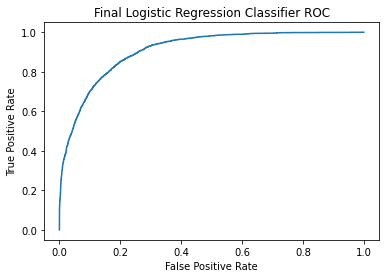

In [138]:
y_val_pred_score = logist_best.decision_function(X_test)

fpr, tpr, _ = roc_curve(y_test, y_val_pred_score, pos_label=logist_best.classes_[1])
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.title("Final Logistic Regression Classifier ROC")
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)

The final model's ROC on the test data is 0.908 -- which beats the initial model's ROC on the training data.

In [153]:
coefs = pd.DataFrame(data=[logist_best.coef_[0].tolist(), X.columns.tolist()]).T
coefs.columns = ['coef', 'feature']
coefs.sort_values(by='coef')

,coef,feature
97,-1.347957,native-country_South
40,-0.957089,occupation_Farming-fishing
43,-0.860257,occupation_Other-service
53,-0.775783,relationship_Own-child
66,-0.772034,native-country_Columbia
...,...,...
64,0.843078,native-country_Canada
94,0.875214,native-country_Portugal
55,0.938894,relationship_Wife
31,1.995656,marital-status_Married-civ-spouse


From the coefficients of our best logistic regression model, it's easy to see why the classification works well from the features provided. In retrospect, the highest-valued coefficients are obviously explanatory: high capital gains are inextricably tied to high income, and being in a marriage all but guarantees one's income to be higher than those that are not. Additionally, having a home country that is a prosperous, Western nation leads a person to be more likely to earn more income than someone from a third-world country like Colombia. Likewise, having the occupation of a service worker, farmer or fisher is traditionally associated with lower incomes, as is being an emancipated child.